# Feature Engineering

In [1]:
import sys
import pandas as pd
sys.path.append('../')
from utils.engineering import saving_dataset, Plots, ColumnMapping

# Data

In [2]:
df = pd.read_csv("./Data/clean_desafio_indicium_imdb.csv")
df.head()

,series_title,released_year,certificate,runtime,genre,imdb_rating,overview,meta_score,director,star1,star2,star3,star4,no_of_votes,gross
0,The Godfather,1972,A,175,"['Crime', 'Drama']",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0
1,The Dark Knight,2008,UA,152,"['Action', 'Crime', 'Drama']",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
2,The Godfather: Part II,1974,A,202,"['Crime', 'Drama']",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0
3,12 Angry Men,1957,U,96,"['Crime', 'Drama']",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0
4,The Lord of the Rings: The Return of the King,2003,U,201,"['Action', 'Adventure', 'Drama']",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,377845905.0


In [3]:
plotter = Plots(df)

# Correlation Matrix

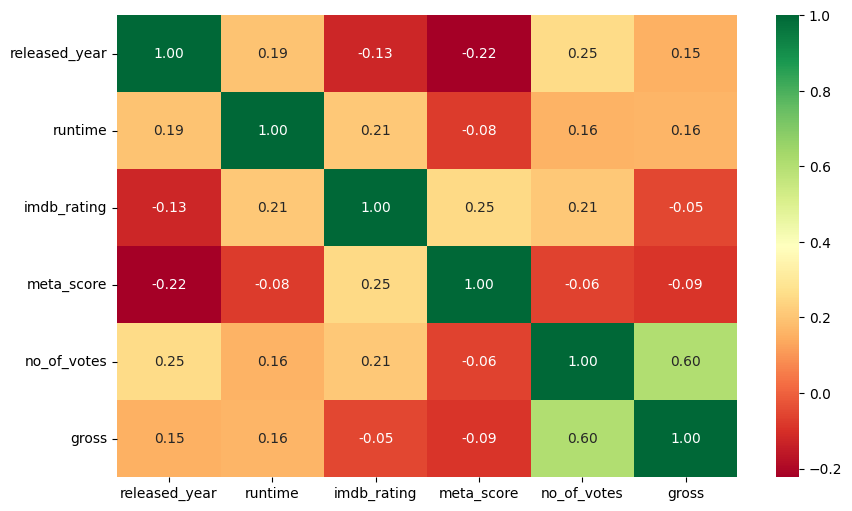

In [28]:
plotter.plot_corr("spearman", figsize=(10, 6))

### Observations:
- The "spearman" method is used to make sure the correlation is robust against the outliers, and to handle non-linear relations
- `no_of_votes` and `gross` have a moderate positive correlation, like it was shown in the EDA
- `runtime`, `meta_score`, `no_of_votes` all have a small correlation with `imdb_rating`
- `released_year` confirmed what was found in the EDA, with small correlations to other numerical columns

# Feature Engineering

In [4]:
df = df.drop(columns=["series_title", "overview"])

### Another feature that can be tested is `movie_age`, to see if there's any differece in its relationship with the target

In [5]:
df["movie_age"] = 2024 - df["released_year"]
df["gross_per_vote"] = df["gross"] / df["no_of_votes"]
df["meta_per_minute"] = df["meta_score"] / df["runtime"]
plotter = Plots(df)

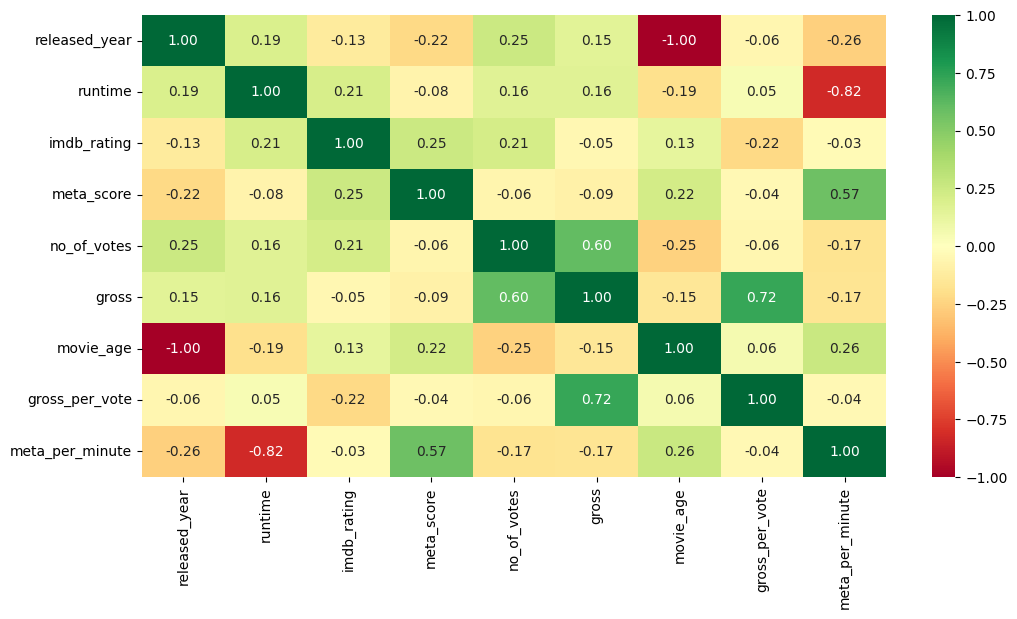

In [30]:
plotter.plot_corr("spearman", figsize=(12, 6))

### Observations:
- `movie_age` shows the same correlation value with the target as `released_year`, the difference being that it's positive now
- The new feature `gross_per_vote` showed a small negative correlation with the target
- New column `meta_per_minute` didn't show any correlation with the target
### Impact:
- Since the correlation value is the same for `movie_age` and `released_year`, is safe to assume that `movie_age` can be dropped and `released_year` can be scaled, preserving its order, but helping the models handle the data is the best possible way
- The new feature `gross_per_vote` shows a good correlation to the target in comparison to the other ones, so it's safe to assume that it will be important to the model and will actually help in the predictions
- `meta_per_minute` wasn't a successful feature, so it can be dropped

In [6]:
df = df.drop(columns=["movie_age", "meta_per_minute"])

## Features Distributions

### As it was seen in the EDA, most numerical columns have a highly positive skewed distributions. Since the scaling and the models tend to have better performances with normally distributed data, we can see which method of transformation is better for that specific column

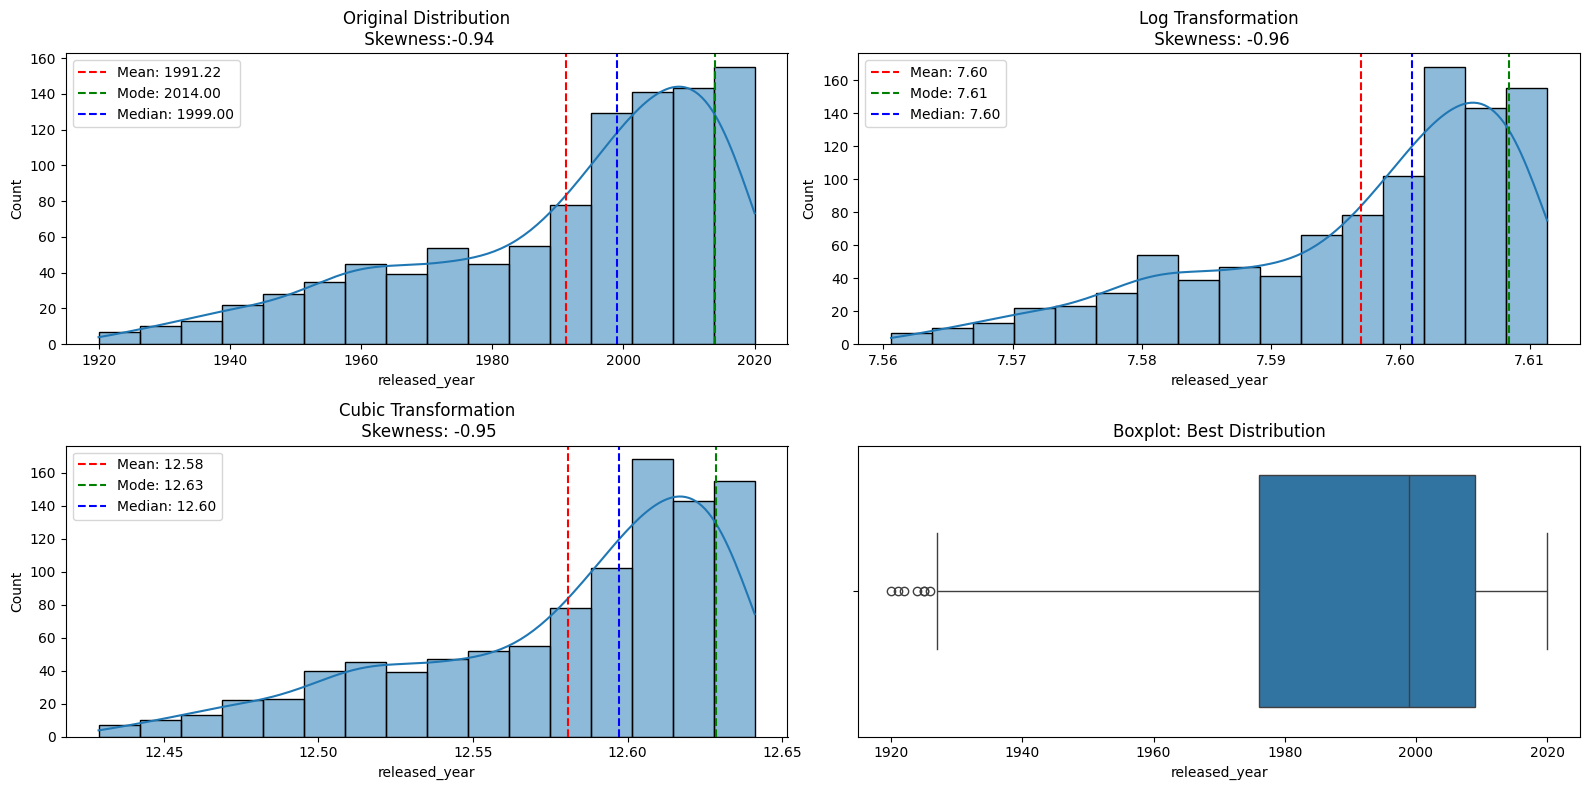

In [33]:
plotter.plot_transformed_distributions("released_year")

### For `released_year`, no transformation is needed

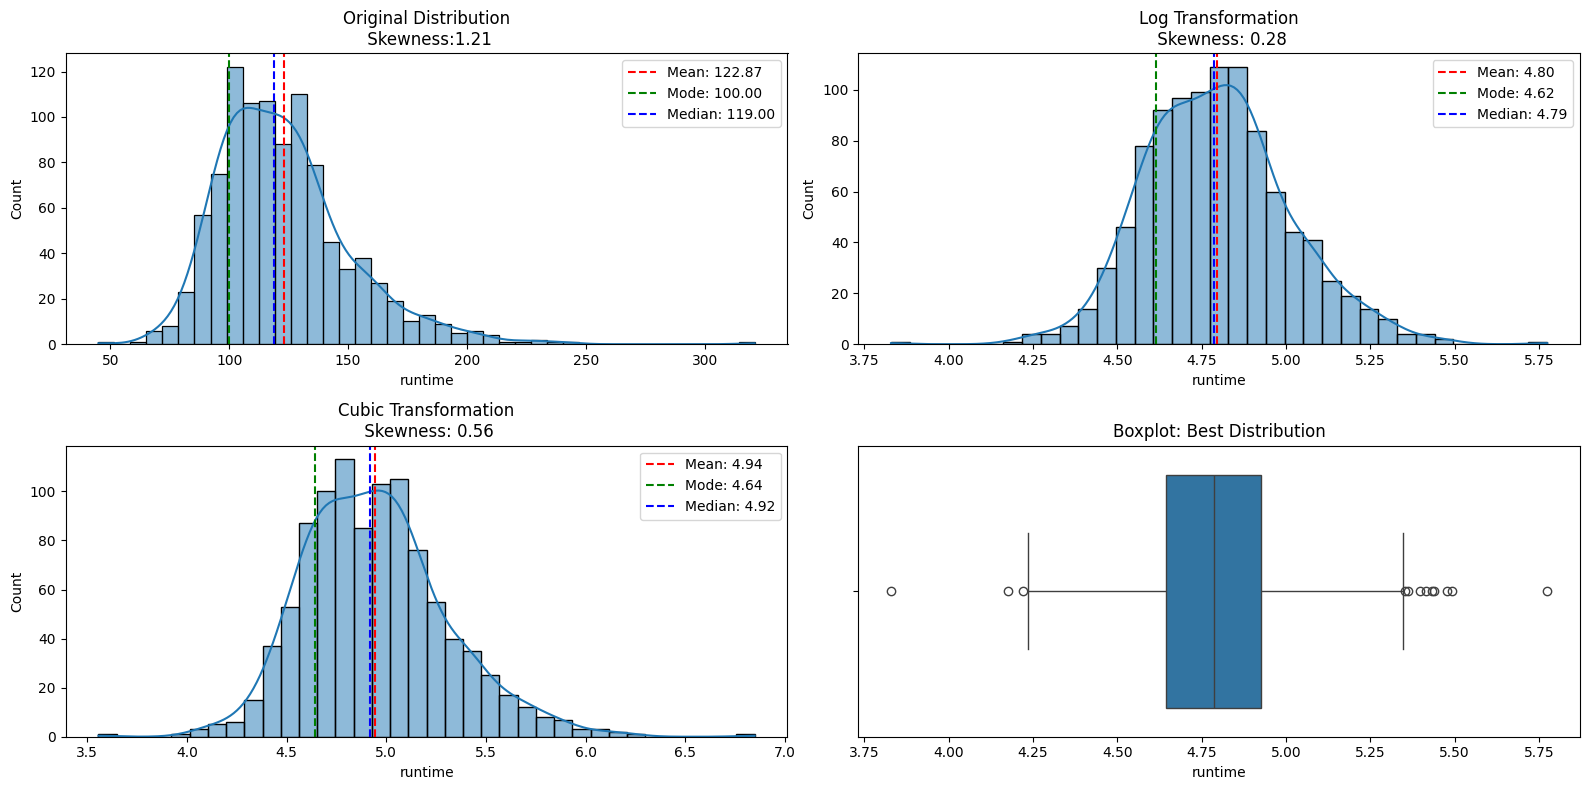

In [33]:
plotter.plot_transformed_distributions("runtime")

### For `runtime`, the log transformation is the best one, and there are still outliers

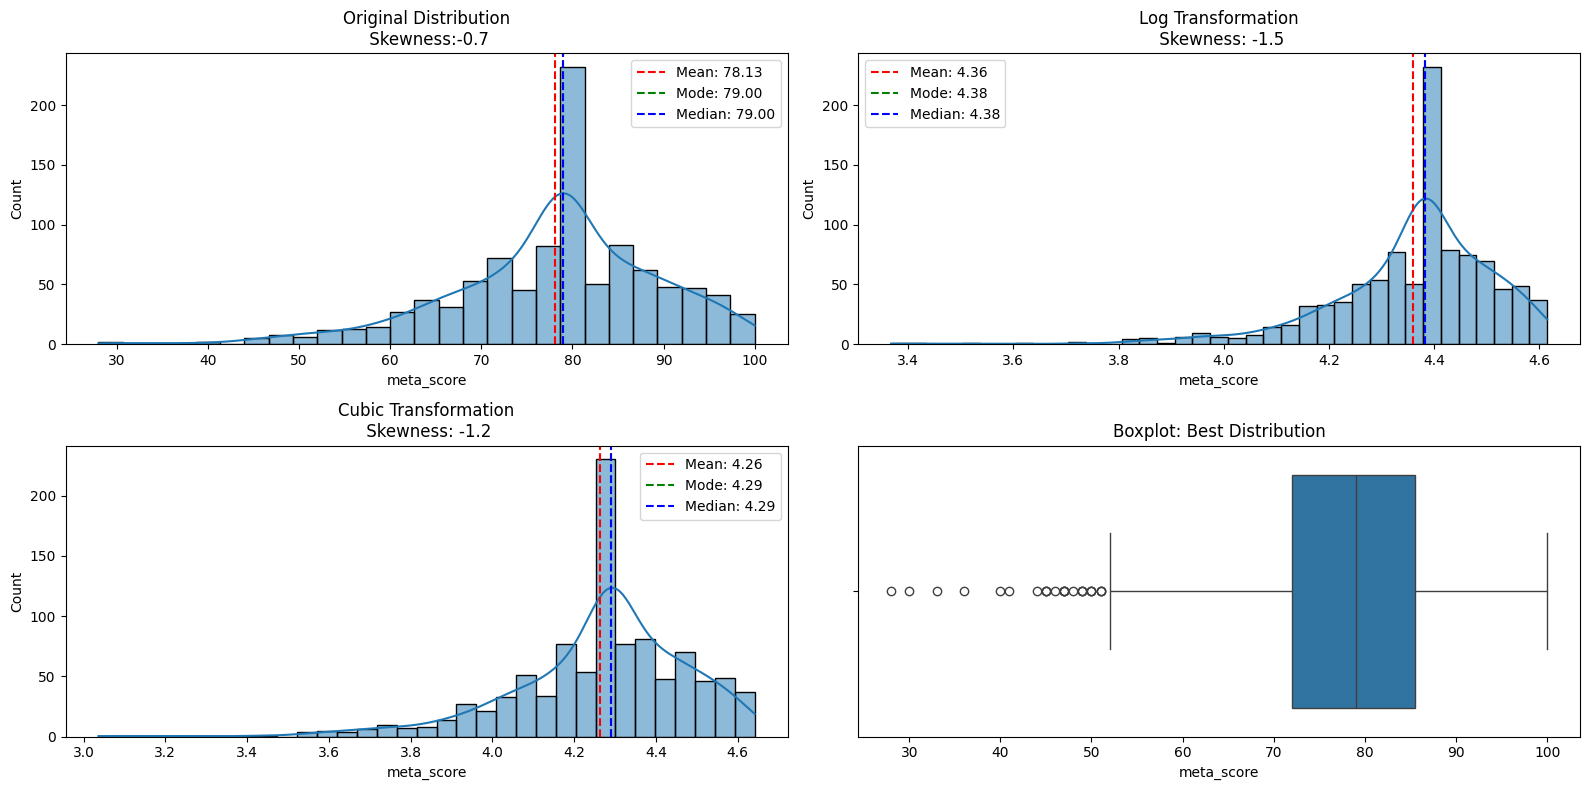

In [34]:
plotter.plot_transformed_distributions("meta_score")

### For `meta_score`, no transformation is needed, and the outliers will be treated in the scaling

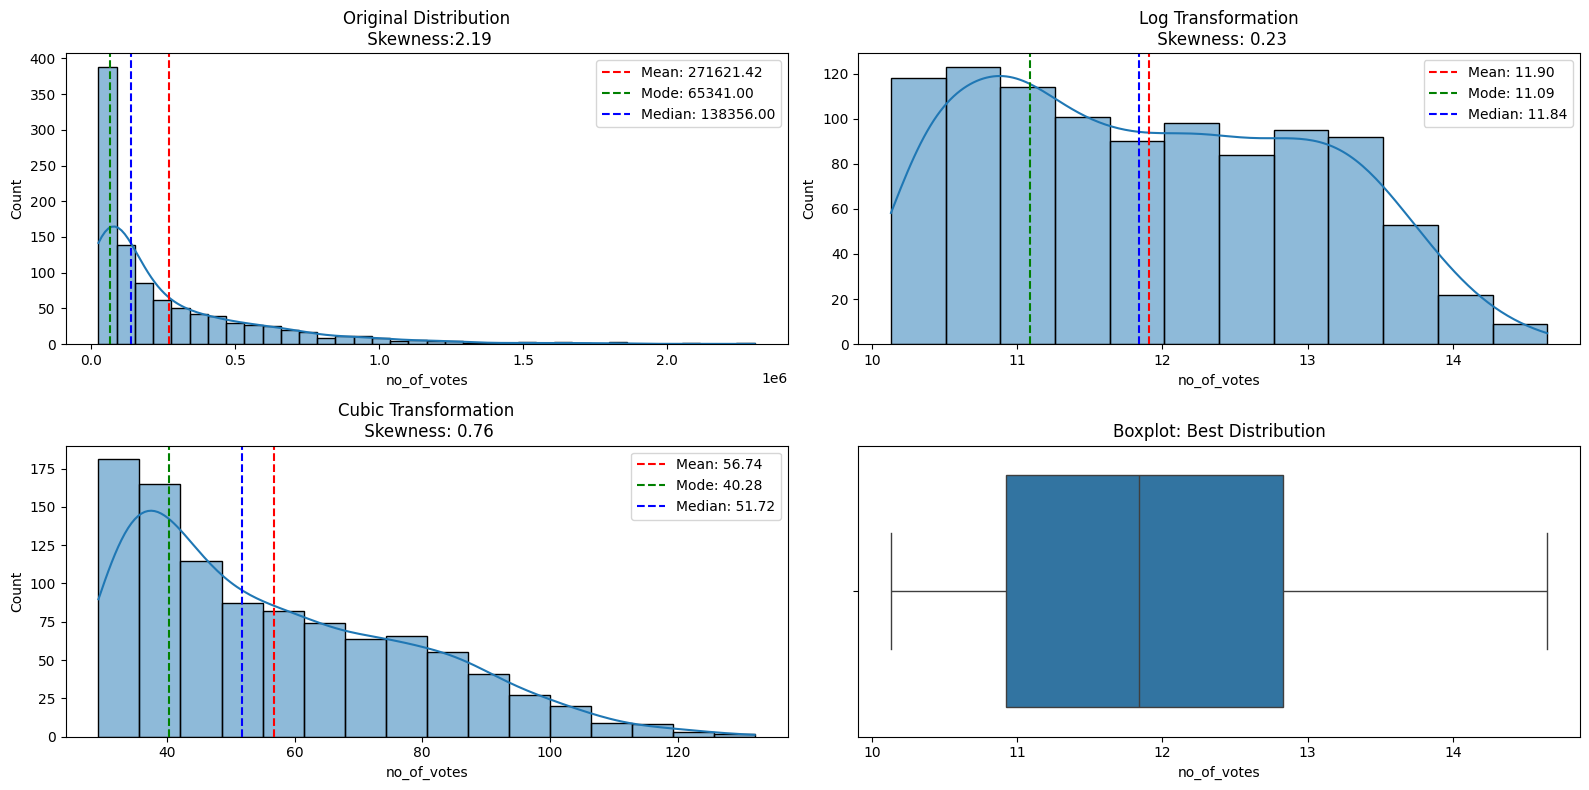

In [35]:
plotter.plot_transformed_distributions("no_of_votes")

### For `no_of_votes`, the log transformation is the best one, and there's no outliers

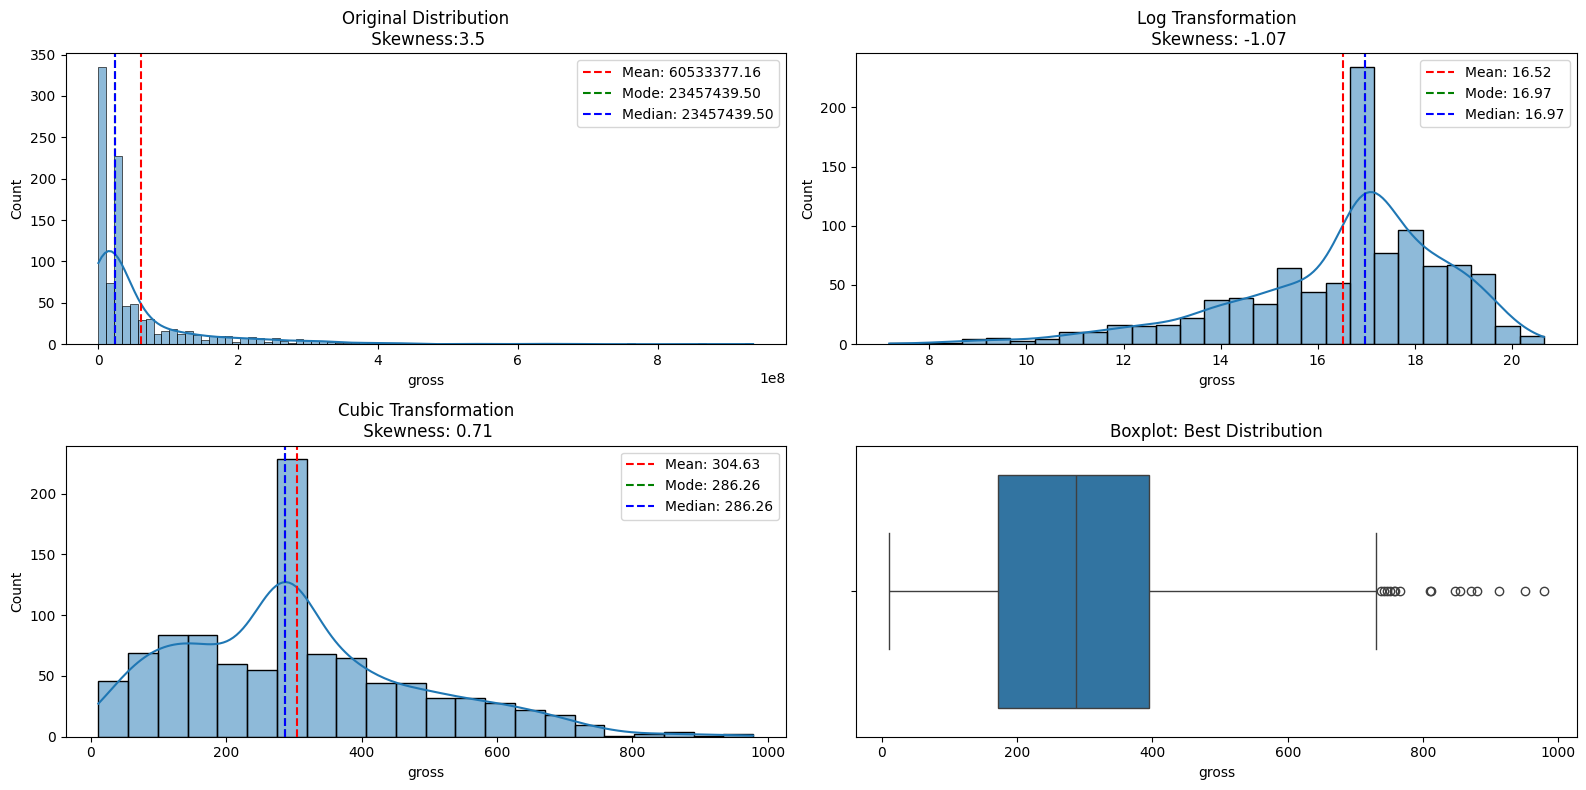

In [36]:
plotter.plot_transformed_distributions("gross")

### For `gross`, the cubic root transformation is the best one, and there are still outliers

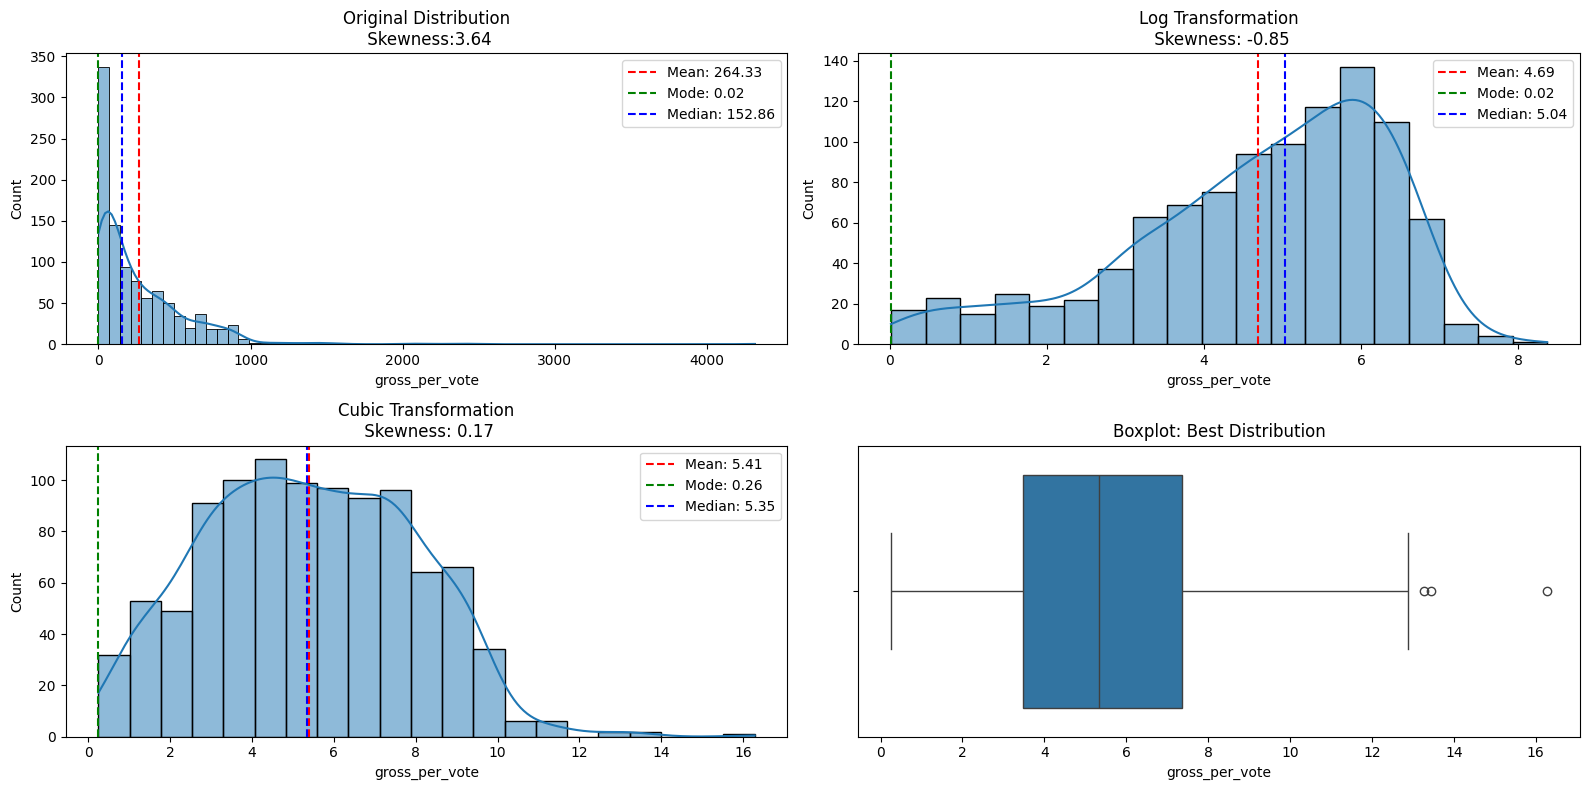

In [37]:
plotter.plot_transformed_distributions("gross_per_vote")

### For `gross_per_vote`, the cubic root transformation is the best one, and there are still a few outliers

### Based on the information gathered:
### `runtime`, `no_of_votes` = Log Transformation
### `gross`, `gross_per_vote` = Cubic Root Transformation
### `released_year`, `meta_score` = No transformation needed

## Grouping and mapping the categorical features

### To make sure that when the model goes into production, the encoding of the features will be done in the correct way, I will map all values of the categorical columns, except `genre`. By doing this, when the user inputs the name of an actor, the preprocessor will have a mapping pkl file to use and correctly categorize and encode this name
### To group the `certificate` column, I will use the IMDB Help Center, where there's a page with all certificates per country. That way, I won't misclassify a movie. The categories are: **all_ages**, **watch_with_parents**, **teens**, **adults** and **unrated**
### For `director` and all `star` columns, I will check how many times each value appears the most in each column and create the same categories for all of these columns.

In [6]:
columns = ["director", "star1", "star2", "star3", "star4",]
for col in columns:
    print(f"Values of {col}")
    print(df.groupby(col)[col].transform("count").value_counts())
    print("*"*50)

Values of director
director
1     353
2     196
3     129
4      76
5      65
6      42
8      32
9      27
7      21
10     20
14     14
13     13
11     11
Name: count, dtype: int64
**************************************************
Values of star1
star1
1     502
2     176
3      96
4      48
6      36
5      35
8      24
7      21
10     20
9      18
12     12
11     11
Name: count, dtype: int64
**************************************************
Values of star2
star2
1    728
2    158
3     69
4     32
7      7
5      5
Name: count, dtype: int64
**************************************************
Values of star3
star3
1    808
2    128
3     30
4     28
5      5
Name: count, dtype: int64
**************************************************
Values of star4
star4
1    881
2    108
3      6
4      4
Name: count, dtype: int64
**************************************************


### In all columns, the number 1 was by far the one that most appeared. Also, we can see that number 2 is the second most used number, and up from 5, it's almost the same amount. So, the categories will be divided into: **one_movie** for when an actor or director only appeared one time in the column, **few_movies** when the person appears 2 to 5 times in the column, and **multiple_movies** when the person appears more than 5 times
### Also, let's format the whole dataset to be in lowercase, to help with the encoding and to put everything in the same standard

In [8]:
for col in df.select_dtypes("object"):
    df[col] = df[col].str.lower()

In [11]:
df_mapped_onehot = df.copy()
group_and_mapp = ColumnMapping(df_mapped_onehot)
cols_to_map = df_mapped_onehot.drop(columns=["genre"]).select_dtypes("object").columns
df_mapped_onehot, mappings_onehot = group_and_mapp.create_column_mapping(cols_to_map, mapping_type=1)
group_and_mapp.save_mapping(mappings_onehot, "../artifacts", "column_mappings_onehot")

### Another thing that can be done is to create another dataframe, but instead of creating categories to be onehot encoded, we can basically label encode these columns, following the order of the categories created in the previous dataset. This way, we can test this dataset with the models to see if there's any impact on performance. Similar to `released_date`, these columns will be scaled, preserving the order of the numbers

In [12]:
df_mapped_label = df.copy()
group_and_mapp = ColumnMapping(df_mapped_label)
cols_to_map = df_mapped_label.drop(columns=["genre"]).select_dtypes("object").columns
df_mapped_label, mappings_onehot = group_and_mapp.create_column_mapping(cols_to_map, mapping_type=2)
group_and_mapp.save_mapping(mappings_onehot, "../artifacts", "column_mappings_label")

# Saving the files

### Old dataframe

In [13]:
df.head()

,released_year,certificate,runtime,genre,imdb_rating,meta_score,director,star1,star2,star3,star4,no_of_votes,gross,gross_per_vote
0,1972,a,175,"['crime', 'drama']",9.2,100.0,francis ford coppola,marlon brando,al pacino,james caan,diane keaton,1620367,134966411.0,83.293730
1,2008,ua,152,"['action', 'crime', 'drama']",9.0,84.0,christopher nolan,christian bale,heath ledger,aaron eckhart,michael caine,2303232,534858444.0,232.220829
2,1974,a,202,"['crime', 'drama']",9.0,90.0,francis ford coppola,al pacino,robert de niro,robert duvall,diane keaton,1129952,57300000.0,50.710119
3,1957,u,96,"['crime', 'drama']",9.0,96.0,sidney lumet,henry fonda,lee j. cobb,martin balsam,john fiedler,689845,4360000.0,6.320260
4,2003,u,201,"['action', 'adventure', 'drama']",8.9,94.0,peter jackson,elijah wood,viggo mortensen,ian mckellen,orlando bloom,1642758,377845905.0,230.007040


### New dataframes

In [14]:
df_mapped_onehot.head()

,released_year,certificate,runtime,genre,imdb_rating,meta_score,director,star1,star2,star3,star4,no_of_votes,gross,gross_per_vote
0,1972,adults,175,"['crime', 'drama']",9.2,100.0,few_movies,few_movies,few_movies,one_movie,few_movies,1620367,134966411.0,83.293730
1,2008,watch_with_parents,152,"['action', 'crime', 'drama']",9.0,84.0,multiple_movies,multiple_movies,few_movies,one_movie,few_movies,2303232,534858444.0,232.220829
2,1974,adults,202,"['crime', 'drama']",9.0,90.0,few_movies,multiple_movies,few_movies,few_movies,few_movies,1129952,57300000.0,50.710119
3,1957,all_ages,96,"['crime', 'drama']",9.0,96.0,few_movies,few_movies,one_movie,few_movies,one_movie,689845,4360000.0,6.320260
4,2003,all_ages,201,"['action', 'adventure', 'drama']",8.9,94.0,few_movies,few_movies,few_movies,one_movie,few_movies,1642758,377845905.0,230.007040


In [15]:
df_mapped_label.head()

,released_year,certificate,runtime,genre,imdb_rating,meta_score,director,star1,star2,star3,star4,no_of_votes,gross,gross_per_vote
0,1972,3,175,"['crime', 'drama']",9.2,100.0,2,2,2,1,2,1620367,134966411.0,83.293730
1,2008,1,152,"['action', 'crime', 'drama']",9.0,84.0,3,3,2,1,2,2303232,534858444.0,232.220829
2,1974,3,202,"['crime', 'drama']",9.0,90.0,2,3,2,2,2,1129952,57300000.0,50.710119
3,1957,0,96,"['crime', 'drama']",9.0,96.0,2,2,1,2,1,689845,4360000.0,6.320260
4,2003,0,201,"['action', 'adventure', 'drama']",8.9,94.0,2,2,2,1,2,1642758,377845905.0,230.007040


In [16]:
saving_dataset(df_mapped_onehot, "data", "ml_dataset_onehot")
saving_dataset(df_mapped_label, "data", "ml_dataset_label")